In [47]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Encoder模型定义

In [75]:
class Encoder(nn.Module):
    def __init__(self, embed_size, vocab_size, enc_hidden_size, dec_hidden_size):
        '''构造方法.
        Args:
            embed_size: 词向量维度
            vocab_size: 词典大小
            enc_hidden_size: Encoder的隐藏状态维度
            dec_hidden_size: Decoder的隐藏状态维度
        '''
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, enc_hidden_size)
        self.linear = nn.Linear(enc_hidden_size, dec_hidden_size)
        
    def forward(self, input_seq):
        '''前向传播.
        Args:
            input_seq: 输入序列, shape (N, batch_size)
        Returns:
            encoder_outputs: 每个时间步的输出(N, batch_size, enc_hidden_size)
            last_hidden: 最后一个时间步的输出(1, batch_size, dec_hidden_size)
        '''
        # 判断是否有batch_size维度
        if input_seq.dim() < 2:
            input_seq = input_seq.view(-1, 1)
        # 保证序列长度至少为2
        if len(input_seq) < 2:
            input_seq = input_seq.repeat(2, 1)
        embed = self.embed(input_seq)
        encoder_outputs, last_hidden = self.rnn(embed)
        last_hidden = torch.tanh(self.linear(last_hidden))
        return encoder_outputs, last_hidden

### 测试Encoder

In [76]:
VOCAB_SIZE = 100
EMBED_SIZE = 20
ENC_HIDDEN_SIZE = 30
DEC_HIDDEN_SIZE = 40
ATT_SIZE = 30

SEQ_LEN = 10
BATCH_SIZE = 3

CUDA = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(CUDA)

cuda


## Attention模型定义

In [77]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size, att_size):
        '''构造方法.
        Args:
            enc_hidden_size:
            dec_hidden_size:
            att_size:
        '''
        super().__init__()
        self.linear_1 = nn.Linear(enc_hidden_size, att_size)
        self.linear_2 = nn.Linear(dec_hidden_size, att_size)
        
    def forward(self, encoder_outputs, decoder_hidden):
        # 首先将二者变换到att_size
        query = self.linear_1(encoder_outputs)
        key = self.linear_2(decoder_hidden)
        scores = torch.softmax((key * query).sum(dim=2), dim=0) #(N, batch_size)
        
        # (1, batch_size, enc_hidden_size)
        weighted_val = (scores.unsqueeze(2) * encoder_outputs).sum(dim=0, keepdim=True)
        
        return weighted_val, scores

## Decoder模型定义

In [79]:
class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, dec_hidden_size, enc_hidden_size, att_size):
        '''构造方法.
        Args:
            embed_size:
            vocab_size:
            dec_hidden_size:
            enc_hidden_size:
            att_size:
        '''
        super().__init__()
        self.dec_hidden_size = dec_hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+enc_hidden_size, dec_hidden_size)
        self.att = Attention(enc_hidden_size, dec_hidden_size, att_size)
        self.linear = nn.Linear(dec_hidden_size, vocab_size)
        
    def forward(self, tgt_seq, encoder_outputs, hidden):
        # 判断是否有batch_size维度
        if tgt_seq.dim() < 2:
            tgt_seq = tgt_seq.view(-1, 1)
        # 保证序列长度至少为2
        if len(tgt_seq) < 2:
            tgt_seq = tgt_seq.repeat(2, 1)
        embed = self.embed(tgt_seq) #(N, batch_size, embed_size)
        max_len, batch_size = embed.shape[0], embed.shape[1]
        
        tgt_seq_hat = torch.zeros(max_len, embed.shape[1], self.dec_hidden_size, device=CUDA)
        att_scores = torch.zeros(max_len, encoder_outputs.shape[0], embed.shape[1], device=CUDA)
        
        for idx in range(1, max_len):
            weight_val, scores = self.att(encoder_outputs, hidden) #(1, batch_size, enc_hidden_size)
            rnn_input = torch.cat((embed[idx-1:idx], weight_val), dim=2)
            decoder_output, hidden = self.rnn(rnn_input, hidden)
            tgt_seq_hat[idx] = decoder_output
            att_scores[idx] = scores
            
        tgt_seq_hat = torch.tanh(self.linear(tgt_seq_hat))
        return tgt_seq_hat, hidden, att_scores

## Seq2Seq模型定义

In [80]:
class Seq2Seq(nn.Module):
    def __init__(self, enc:Encoder, dec:Decoder):
        super().__init__()
        self.enc = enc
        self.dec = dec
        
    def forward(self, src_seq, tgt_seq):
        encoder_outputs, last_hidden = self.enc(src_seq)
        tgt_seq_hat, _, att_scores = self.dec(tgt_seq, encoder_outputs, last_hidden)
        return tgt_seq_hat, att_scores

In [81]:
enc = Encoder(EMBED_SIZE, VOCAB_SIZE, ENC_HIDDEN_SIZE, DEC_HIDDEN_SIZE)
dec = Decoder(EMBED_SIZE, VOCAB_SIZE, DEC_HIDDEN_SIZE, ENC_HIDDEN_SIZE, ATT_SIZE)

seq2seq = Seq2Seq(enc, dec)

x = torch.empty(50, 10, 3, dtype=torch.long, device=CUDA).random_(VOCAB_SIZE)
y = torch.empty(50, 7, 3, dtype=torch.long, device=CUDA).random_(VOCAB_SIZE)

seq2seq.to(CUDA)

Seq2Seq(
  (enc): Encoder(
    (embed): Embedding(100, 20)
    (rnn): GRU(20, 30)
    (linear): Linear(in_features=30, out_features=40, bias=True)
  )
  (dec): Decoder(
    (embed): Embedding(100, 20)
    (rnn): GRU(50, 40)
    (att): Attention(
      (linear_1): Linear(in_features=30, out_features=30, bias=True)
      (linear_2): Linear(in_features=40, out_features=30, bias=True)
    )
    (linear): Linear(in_features=40, out_features=100, bias=True)
  )
)

In [109]:
def train_model(seq2seq, x, y, epochs=10, lr=0.01):
    seq2seq.train()
    criterion = nn.CrossEntropyLoss()
    trainer = optim.Adam(seq2seq.parameters(), lr=lr)
    n = len(x)
    losses = torch.zeros(epochs)
    for idx in range(epochs):
        for xx, yy in zip(x, y):
            yy_hat, _ = seq2seq(xx, yy)
            yy_hat = yy_hat.transpose(1, 2)
            loss = criterion(yy_hat[1:], yy[1:])
            loss.backward()
            trainer.step()
            trainer.zero_grad()
            losses[idx] += loss.cpu().detach().item()
            
    return losses/n

In [117]:
losses = train_model(seq2seq, x, y, 20, 0.001)

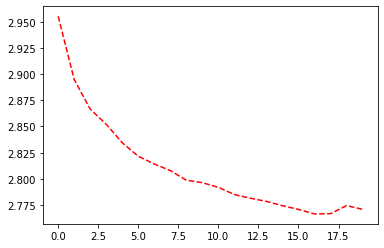

In [118]:
plt.plot(losses, 'r--')
plt.show()

In [102]:
def translate(enc, dec, input_seq, sos_token, max_len, tgt_vocab_size):
    enc.eval()
    dec.eval()
    
    with torch.no_grad():
        encoder_outputs, hidden = enc(input_seq)
        batch_size = encoder_outputs.shape[1]
        outs = torch.zeros(max_len, batch_size, tgt_vocab_size, device=CUDA)
        att_scores = torch.zeros(max_len, encoder_outputs.shape[0], batch_size, device=CUDA)
        decoder_input = sos_token

        for idx in range(max_len):
            decoder_output, hidden, att_score = dec(decoder_input, encoder_outputs, hidden)
            att_scores[idx] = att_score[-1]
            outs[idx] = decoder_output[-1]
            decoder_input = torch.argmax(outs[idx:idx+1], dim=2)
        
    return torch.argmax(outs, dim=2), att_scores

In [147]:
print(x[1, :, 2], y[1, :, 2])

tensor([28, 92, 93,  7, 79, 99, 32, 31, 50,  8], device='cuda:0') tensor([28, 53, 24, 24, 35, 85, 76], device='cuda:0')


In [148]:
outs, scores = translate(enc, dec, x[1, :, 2], y[1, 0, 2], 6, VOCAB_SIZE)

In [149]:
print(outs.squeeze())

tensor([53, 24, 80, 88, 97, 38], device='cuda:0')


In [150]:
scores.shape

torch.Size([6, 10, 1])

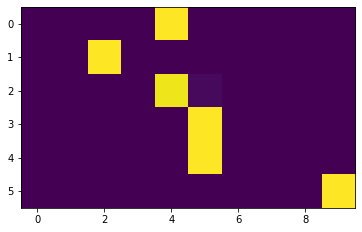

In [151]:
plt.imshow(scores[:, :, 0].cpu())
plt.show()